© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# 🔗 Neural Networks

**Neural networks (NNs)** are machine learning models composed of multiple connected linear units, called **neurons** or **perceptrons**. These neurons are arranged in layers and connected via directed edges, forming a **computation graph**. Each edge represents data flow — the output of one neuron is passed as input to another.

<center>
<img src="images/nn.png" alt="Neural network diagram" width="700"/>
</center>

The diagram above shows a **fully-connected neural network**, also known as a **multi-layer perceptron (MLP)**. This type of network is defined by:

- Its **depth** $L \in \mathbb{N}$ — the number of **hidden layers**
- Its **layer widths** $(n_0, n_1, \dots, n_{L+1}) \in \mathbb{N}^{L+2}$, where $n_0$ is the input dimension and $n_{L+1}$ is the output dimension.

In the example above, we have:
- $L = 3$ (three hidden layers)
- Layer widths: $n_0 = 4,\ n_1 = n_2 = n_3 = 5,\ n_4 = 3$


## 🧱 Other Neural Network Architectures

Besides fully-connected networks, there are many common NN architectures designed for specific data types, e.g.:

- **Convolutional Neural Networks (CNNs)**: Designed for data with translation invariances (e.g. images)
- **Recurrent Neural Networks (RNNs)**: Designed for sequential/time series data (use **cycles** in the computation graph, unlike **feedforward** NNs)
- **Transformers**: Used in modern LLMs, designed for tasks where context is important for predictions

In this course, we will implement only **fully-connected feedforward networks**.


## 🔌 Neurons and Layers

Each **neuron** applies a linear transformation followed by a non-linear **activation function** $\sigma$. The output of the entire network is defined as a **nested composition** of affine functions and activations:

$$
h(x) = W^{(L)} \sigma\left( W^{(L-1)} \sigma\left( \dots \sigma\left( W^{(0)} x + b^{(0)} \right) + \dots + b^{(L-1)} \right) \right) + b^{(L)},
$$
where the trainable parameters are:
- **Weights** of layer $\ell$: $W^{(\ell)} \in \mathbb{R}^{n_{\ell+1} \times n_\ell}$
- **Biases** of layer $\ell$: $b^{(\ell)} \in \mathbb{R}^{n_{\ell+1}}$

This function $h(x)$ maps an input $x \in \mathbb{R}^{n_0}$ to an output in $\mathbb{R}^{n_{L+1}}$.

### 🔁 Layer-wise Notation

We define the **activation** vector (after applying $\sigma$) at layer $\ell$ as:

$$
a^{(\ell)} := \sigma\left( z^{(\ell)} \right), \quad \text{where} \quad z^{(\ell)} := W^{(\ell - 1)} a^{(\ell - 1)} + b^{(\ell - 1)}
$$

with:
- Input layer: $a^{(0)} := x$
- Output layer: $a^{(L+1)} := z^{(L+1)} = h(x)$

Here:
- $z^{(\ell)}$ is the **pre-activation** value
- $a^{(\ell)}$ is the **(post-)activation** (output of the layer)

This layered structure allows neural networks to approximate complex, non-linear functions in hierarchical way — a core reason for their success in many domains.

### 🔍 Notes

- In this setup, we use a **linear output layer** (no activation in the final layer).
- Typically, the same activation function $\sigma$ (e.g., ReLU, tanh) is used for all **hidden layers**.
- It is common to use a **different activation** (e.g., softmax) in the output layer for classification tasks.



## 🔁 Backpropagation

**Backpropagation** is an algorithm used to train feedforward neural networks. It efficiently computes the gradients of the loss function with respect to all weights and biases in the network — making training of deep NNs possible.

### 🎯 Objective

We consider the empirical loss (risk) over a dataset of $N$ examples:

$$
\hat{\mathcal{L}}(X, Y) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(y_i, h(x_i)),
$$

where:
- $\mathcal{L}$ is a sample-wise loss (e.g., MSE, cross-entropy)
- $h(x)$ is the output of the neural network


### 🧩 Chain Rule for Gradients

Observe that the output $h(x)$ depends:
- **Directly** on the final layer parameters $W^{(L)}$, $b^{(L)}$
- **Indirectly** on earlier parameters, only via layer-wise activations $a^{(\ell)}$

To compute the gradient with respect to parameters in earlier layers, we apply the **chain rule**:

$$
\nabla_{W^{(\ell)}} \hat{\mathcal{L}} = 
\frac{\partial \hat{\mathcal{L}}}{\partial h(x)} \odot 
\frac{\partial h(x)}{\partial a^{(L-1)}} \odot 
\cdots \odot 
\frac{\partial a^{(\ell)}}{\partial z^{(\ell)}} \cdot 
\frac{\partial z^{(\ell)}}{\partial W^{(\ell)}},
$$

where $\odot$ is the component-wise product and $\cdot$ is the matrix product. Naively computing this for all layers would be expensive, but **most computations are shared across layers** and can be reused recursively.


### ⚙️ Defining Layer-Wise Errors

Define the **error** in layer $\ell$ for neuron $j$ as:

$$
\delta_j^{(\ell)} := \frac{\partial \hat{\mathcal{L}}}{\partial z_j^{(\ell)}}
$$

Let $\delta^{(\ell)}$ denote the full vector of errors in layer $\ell$. These can be **computed in reverse order** (hence the name "backpropagation"):

#### 🟩 Output layer:
If no activation is used in the output layer:
$$
\delta^{(L+1)} = \frac{\partial \hat{\mathcal{L}}}{\partial h(x)}
$$

If an activation function $\alpha$ is used:
$$
\delta^{(L+1)} = \frac{\partial \hat{\mathcal{L}}}{\partial h(x)} \odot \alpha'(h(x))
$$

#### 🟩 Hidden layers:
For $\ell = L, \dots, 1$:

$$
\delta^{(\ell)} = \frac{\partial \hat{\mathcal{L}}}{\partial z_j^{(\ell+1)}} \cdot \frac{\partial  z_j^{(\ell+1)}}{\partial z_j^{(\ell)}}= 
\left(W^{(\ell)}\right)^\top \delta^{(\ell+1)} \odot \sigma'\left(z^{(\ell)}\right)
$$

This recursive formula allows us to compute all errors from the output layer backwards to the input.


### 📐 Computing Gradients

Once the error vectors $\delta^{(\ell)}$ are known, gradients of the loss with respect to parameters are:

- **Weights:**
$$
\nabla_{W^{(\ell)}} \hat{\mathcal{L}} = \delta^{(\ell+1)} \otimes a^{(\ell)}
$$

- **Biases:**
$$
\nabla_{b^{(\ell)}} \hat{\mathcal{L}} = \delta^{(\ell+1)}
$$

Here, $\otimes$ denotes the **outer product**.


### 🚀 Backpropagation Algorithm Summary

Given a mini-batch or full dataset $(x_i, y_i)$:

1. **Forward pass:**
   $$x \to z^{(1)} \to a^{(1)} \to z^{(2)} \to \cdots \to a^{(L)} \to z^{(L+1)} \to h(x)$$

2. **Backward pass:**
   $$
   \delta^{(L+1)} = \frac{\partial \hat{\mathcal{L}}}{\partial h(x)}, \quad
   \delta^{(\ell)} = (W^{(\ell)})^\top \delta^{(\ell+1)} \odot \sigma'(z^{(\ell)}), \quad \ell = L, \dots, 1
   $$

3. **Compute gradients:**
   $$
   \nabla_{W^{(\ell)}} \hat{\mathcal{L}} = \delta^{(\ell+1)} \otimes a^{(\ell)}, \quad
   \nabla_{b^{(\ell)}} \hat{\mathcal{L}} = \delta^{(\ell+1)}
   $$

4. **Update parameters** using gradient descent (or a variant like SGD, Adam, etc.).


### ⚡ Why Backprop Is Efficient

- It **avoids recomputation** by reusing intermediate values ($z^{(\ell)}$, $a^{(\ell)}$).
- It **avoids matrix-matrix multiplications** by propagating scalar/vector operations.
- It **scales linearly** with the number of layers.


# 🧩 Implementation of a Fully-Connected Neural Network

Neural network libraries (like PyTorch or TensorFlow) typically organize models as **compositions of layers**. Each layer performs a specific transformation, and networks are built by stacking these layers in sequence.

We'll adopt this modular approach and implement:

- A **fully-connected (dense) layer**
- A **multi-layer perceptron (MLP)** built from stacked dense layers
- Support for **variable activation functions** and **loss functions**

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

## ⚙️ Activation Functions

To support training via **backpropagation**, our activation functions need to expose not only their value but also their **derivative**.

We'll implement two common activations:

- **ReLU (Rectified Linear Unit)**:
  $$
  \text{ReLU}(x) = \max(0, x)
  $$

- **Linear (identity) activation**:
  $$
  \text{Linear}(x) = x
  $$



In [2]:
class ReLU:
    """ReLU activation function and its subgradient."""

    def __call__(self, x):
        return np.maximum(0, x)

    def grad(self, x):
        return (x > 0).astype(float)


class Linear:
    """Linear activation (identity function) and its derivative."""

    def __call__(self, x):
        return x

    def grad(self, x):
        return np.ones_like(x)


## 🎯 Loss Function

As with activation functions, we will implement **loss functions** as classes that expose both their value and gradient. Here we will only implement **quadratic loss** (MSE), defined as:

$$
\mathcal{L}(y, \hat{y}) = \frac{1}{2} \| y - \hat{y} \|^2
$$


In [3]:
class MSE:
    """Quadratic (L2) loss and its gradient."""

    def __call__(self, Y_pred, Y_true):
        return 0.5 * np.mean((Y_pred - Y_true) ** 2)

    def grad(self, Y_pred, Y_true):
        return (Y_pred - Y_true) / Y_pred.shape[0]


## 🧱 Dense Layer Implementation

We define a reusable **dense layer** (also called a fully-connected layer), which performs a **linear transformation** followed by a **non-linear activation function**. Given input $X \in \mathbb{R}^{N \times d}$ (batch of $N$ inputs with $d$ features), a dense layer computes:

$$
z = XW + b, \quad a = \sigma(z)
$$

Where:
- $W \in \mathbb{R}^{d \times m}$ is the weight matrix
- $b \in \mathbb{R}^{1 \times m}$ is the bias vector
- $\sigma$ is an activation function (e.g., ReLU)
- $a$ is the activation (output of the layer)

### ⚠️ Initialization Matters!

Unlike convex models (such as linear or logistic regression), we **cannot initialize neural network weights to zero**. If all neurons in a layer start with the same weights, they will compute identical outputs and receive identical gradients — a phenomenon known as **symmetry breaking failure**. As a result, all neurons will learn the same features, making the network ineffective.

In fact, for networks with **ReLU activations**, initializing weights to zero is even worse:  
> 🪤 The all-zero point is a **saddle point** for the ReLU network, meaning gradient descent will get stuck and fail to make progress.

#### ✅ He Initialization

To avoid these issues, we initialize weights **randomly** using a principled strategy known as **He initialization** (after [Kaiming He et al.](https://arxiv.org/abs/1502.01852)). It draws weights from a normal distribution:

$$
W_{ij} \sim \mathcal{N}\left(0, \frac{2}{\text{fan-in}}\right)
$$

Here, "fan-in" refers to the number of inputs to a neuron (i.e., the width of the previous layer).

This initialization is specifically designed for ReLU activations. It keeps the variance of activations and gradients approximately constant across layers, which helps avoid exploding or vanishing gradients during training.


In [4]:
class DenseLayer:
    """
    Fully-connected (dense) layer with activation.
    
    Parameters:
    - num_in: number of input neurons
    - num_out: number of output neurons
    - activation: activation class (e.g., ReLU or Linear)
    - layer_name: unique name to identify the layer (used for parameter keys)
    """
    
    def __init__(self, num_in, num_out, activation=ReLU, layer_name=None):
        self.num_in = num_in
        self.num_out = num_out
        self.activation = activation()
        self.name = layer_name or f"Dense_{num_in}_{num_out}"

        # He initialization (good for ReLU)
        self.W = np.random.normal(loc=0.0, scale=np.sqrt(2. / num_in), size=(num_in, num_out))
        self.b = np.zeros((1, num_out))

    def __call__(self, X):
        """
        Forward pass through the layer.
        
        Parameters:
        - X: input matrix of shape (N, num_in)
        
        Returns:
        - z: pre-activation (N, num_out)
        - x: post-activation (N, num_out)
        """
        z = X @ self.W + self.b
        x = self.activation(z)
        return z, x

    def compute_delta(self, z, W_next, delta_next):
        """
        Compute backpropagated error for this layer.
        
        Parameters:
        - z: pre-activation from this layer (N, num_out)
        - W_next: weights of the next layer (num_out, next_layer_size)
        - delta_next: delta from the next layer (N, next_layer_size)
        
        Returns:
        - delta for this layer (N, num_out)
        """
        return (delta_next @ W_next.T) * self.activation.grad(z)

    def loss_grad(self, X_prev, delta):
        """
        Compute gradients w.r.t. weights and biases.
        
        Parameters:
        - X_prev: input to this layer (N, num_in)
        - delta: error signal from this layer (N, num_out)
        
        Returns:
        - Dictionary with gradients for weights and biases
        """
        w_grad = np.mean(delta[:, :, None] * X_prev[:, None, :], axis=0).T  # (num_in, num_out)
        b_grad = np.mean(delta, axis=0, keepdims=True)                      # (1, num_out)

        return {f'{self.name}_W': w_grad, f'{self.name}_b': b_grad}

    def _get_params(self):
        """Return a dictionary of parameters for this layer."""
        return {f'{self.name}_W': self.W, f'{self.name}_b': self.b}


## 🧠 MLP (Multi-Layer Perceptron) Implementation

We now implement a general **multi-layer perceptron (MLP)** model — a feedforward neural network composed of stacked **dense layers**.

Our `MLP` class inherits from `TrainableModel`, just like all previous models we've built with iterative training. It implements the **backpropagation algorithm** to compute gradients layer by layer.

In [5]:
from courselib.models.base import TrainableModel

class MLP(TrainableModel):
    def __init__(self, widths, optimizer, activation=ReLU, output_activation=Linear, loss=MSE):
        """
        Initializes a multi-layer perceptron (MLP) using a sequence of DenseLayers.
        
        Parameters:
        - widths: list of layer sizes, including input and output dimensions
        - optimizer: optimizer instance (must support `update(params, grads)`)
        - activation: activation class for hidden layers
        - output_activation: activation class for the output layer
        - loss: loss function class
        """
        self.optimizer = optimizer
        self.widths = widths
        self.loss = loss()
        
        # Build hidden layers
        self.layers = [
            DenseLayer(widths[i], widths[i+1], activation=activation, layer_name=f"layer_{i}")
            for i in range(len(widths) - 2)
        ]
        
        # Output layer
        self.layers.append(
            DenseLayer(widths[-2], widths[-1], activation=output_activation, layer_name=f"layer_{len(widths)-2}")
        )
    
    def decision_function(self, X):
        """Applies all layers to compute the raw network output."""
        out = X
        for layer in self.layers:
            _, out = layer(out)
        return out
    
    def __call__(self, X):
        return np.argmax(self.decision_function(X), axis=-1)

    def forward_pass(self, X):
        """Computes pre-activations and activations at each layer."""
        x_l = [X]
        z_l = [X]
        for layer in self.layers:
            z, x = layer(x_l[-1])
            z_l.append(z)
            x_l.append(x)
        return z_l, x_l

    def backward_pass(self, X, Y, z_l, x_l):
        """Computes layer-wise gradients using backpropagation."""
        delta = self.loss.grad(x_l[-1], Y) * self.layers[-1].activation.grad(z_l[-1])
        deltas = [delta]
        
        for i in reversed(range(len(self.layers) - 1)):
            delta = self.layers[i].compute_delta(z_l[i+1], self.layers[i+1].W, deltas[-1])
            deltas.append(delta)
        
        return deltas[::-1]

    def loss_grad(self, X, Y):
        """Returns gradients of the loss w.r.t. all layer parameters."""
        z_l, x_l = self.forward_pass(X)
        delta_l = self.backward_pass(X, Y, z_l, x_l)

        grads = {}
        for i, layer in enumerate(self.layers):
            grads.update(layer.loss_grad(x_l[i], delta_l[i]))
        return grads

    def _get_params(self):
        """Returns a dictionary of all layer parameters."""
        params = {}
        for layer in self.layers:
            params.update(layer._get_params())
        return params


# 🌸 Test MLP on the Iris Dataset

In [6]:
from courselib.utils.loaders import load_irises 
from courselib.utils.splits import train_test_split
from courselib.utils.preprocessing import labels_encoding

df = load_irises()

X, Y, X_train, Y_train, X_test, Y_test =  train_test_split(df[['sepal length [cm]', 'petal width [cm]', 'iris type']], 
                                          training_data_fraction=0.8,
                                          return_numpy=True,
                                          class_column_name='iris type')

Y, Y_train, Y_test = labels_encoding(Y), labels_encoding(Y_train), labels_encoding(Y_test)

Loading from local `iris_data_set.csv`...


In [7]:
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import accuracy, mean_squared_error

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}

optimizer = GDOptimizer(learning_rate=0.01)

model = MLP(widths=[2,100,3], optimizer=optimizer, activation=ReLU, output_activation=Linear, loss=MSE)

metrics_history = model.fit(X_train, Y_train, num_epochs=10000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

The final train accuracy: 90.8%
Test accuracy: 90.0%


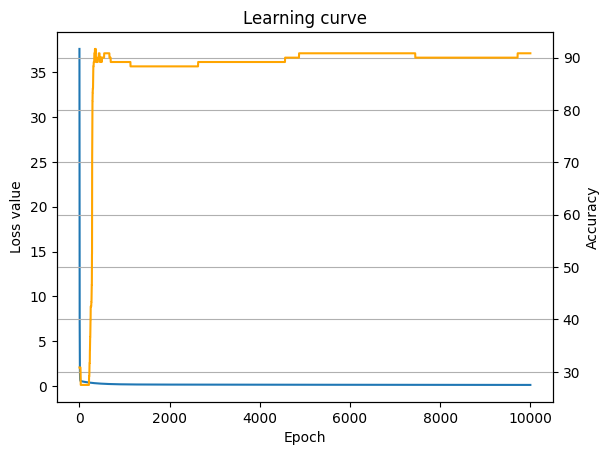

In [8]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), Y_test),1)}%')

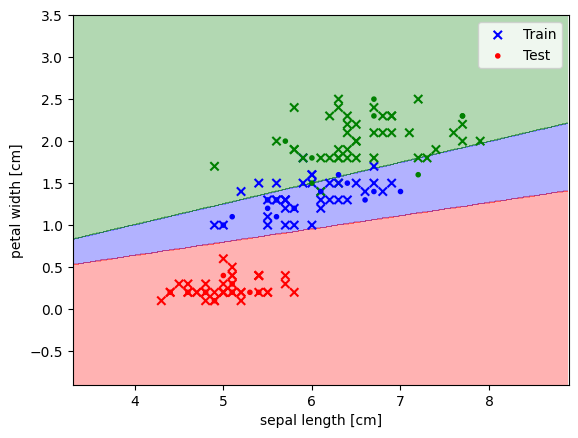

In [9]:
fig, ax = plt.subplots()

x1_min = X_train[:, 0].min() - 1
x1_max = X_train[:, 0].max() + 1
x2_min = X_train[:, 1].min() - 1
x2_max = X_train[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])
h_list = model(X_list)

cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', 
            color=[cmap.colors[y] for y in np.argmax(Y_train,axis=-1)], label='Train')

plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', 
            color=[cmap.colors[y] for y in np.argmax(Y_test,axis=-1)], label='Test')


plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend()

## ⚠️ Challenges in Neural Network Training

Neural networks are far more **expressive** than linear models. In fact, even a network with just a **single hidden layer** can approximate any continuous function on a compact domain with arbitrary precision — a result known as the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

However, just because a function **can** be represented doesn’t mean it’s **easy to find**. In practice, training neural networks comes with several important challenges:

### 🧩 Non-Convex Objective

The loss function of a neural network is **not convex**. Even simple networks have many **parameter permutations** (e.g. swapping neurons in a layer) that result in the same output, meaning:

- There are many **local minima** and **saddle points**.
- Gradient-based training methods (e.g. GD) may get stuck in poor local minima.
- Training is **highly sensitive to initialization** — different initial weights may converge to very different solutions.


### 🛠️ Practical Heuristics

Because neural network training dynamics are difficult to analyze theoretically, there are no universal recipes for finding the best model. However, over time, **practical heuristics** have emerged:

- **Architecture design:** Layer types (e.g., dense, convolutional, residual) suited for particular tasks.
  
- **Optimization strategy:**  Gradient descent is often enhanced with optimizers like **Adam**, **RMSprop**, or **SGD with momentum**, which improve convergence on non-convex surfaces.
  
- **Weight initialization:** Techniques like **He initialization** (for ReLU) or **Xavier/Glorot initialization** (for tanh/sigmoid) help maintain stable gradients throughout the network.


## 🧪 Exercise: Activation and Loss Function Combinations

Implement the following classes:

- **`Sigmoid` activation**:  
  $$
  \sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x))
  $$

- **`CrossEntropy` loss** (for one-hot $Y$ and predicted $\hat{Y}$):  
  $$
  \mathcal{L}(Y, \hat{Y}) = - \sum_k Y[k] \log(\hat{Y}[k])
  $$  

Train your `MLP` with different combinations of activations and loss functions. Which combinations work well, and why?
